# LDP kRR Frequency Estimation under Poisoning Attack

## Problem Setup
This notebook evaluates the robustness of Local Differential Privacy (LDP) using the k-ary Randomized Response (kRR) mechanism under poisoning attacks.
We investigate two adversarial strategies:

- **Output Poisoning Attack (OPA)**: The adversary directly reports a fixed value to bias the output.
- **Input Poisoning Attack (IPA)**: The adversary reports fake inputs which are still subject to the LDP mechanism.

We examine these attacks under two common user distributions:
1. **Uniform Distribution**: All categories are equally likely.
2. **Zipf Distribution**: Realistic, heavy-tailed categorical skew.

In [10]:
## Imports and Parameters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Parameters
n = 10000
k = 20
epsilon = 1.0
target_bin = 0
gamma_values = np.linspace(0, 0.3, 10)
num_trials = 5
# number of trails can be large if more stable results are expected

In [11]:
## Utility Functions
# kRR probability setup
def krr_probabilities(k, epsilon):
    p = np.exp(epsilon) / (np.exp(epsilon) + k - 1)
    q = (1 - p) / (k - 1)
    return p, q

# Zipf distribution generator
def zipf_distribution(k, s=1.0):
    ranks = np.arange(1, k + 1)
    weights = 1 / np.power(ranks, s)
    return weights / weights.sum()

In [12]:
## Core
def simulate_krr(n, k, epsilon, gamma, target_bin, true_freq, attack_type):
    p, q = krr_probabilities(k, epsilon)
    n_corrupt = int(gamma * n)
    n_honest = n - n_corrupt

    honest_data = np.random.choice(k, size=n_honest, p=true_freq)
    reports = []

    for x in honest_data:
        probs = np.full(k, q)
        probs[x] = p
        reports.append(np.random.choice(k, p=probs))

    if attack_type == "OPA":
        reports += [target_bin] * n_corrupt
    elif attack_type == "IPA":
        for _ in range(n_corrupt):
            probs = np.full(k, q)
            probs[target_bin] = p
            reports.append(np.random.choice(k, p=probs))

    reports = np.array(reports)
    est_freq = np.zeros(k)
    for i in range(k):
        count = np.sum(reports == i)
        est_freq[i] = (count / n - q) / (p - q)
    return np.clip(est_freq[target_bin], 0, 1)

In [13]:
## Experiment Runner

def run_experiment(true_freq, title_label):
    results = {"OPA": [], "IPA": []}
    for gamma in gamma_values:
        for attack in ["OPA", "IPA"]:
            trials = [simulate_krr(n, k, epsilon, gamma, target_bin, true_freq, attack) for _ in range(num_trials)]
            mean = np.mean(trials)
            std = np.std(trials)
            results[attack].append((gamma, mean, mean - 2 * std, mean + 2 * std))

    # Plot
    plt.figure(figsize=(8, 5))
    for attack, color in zip(["OPA", "IPA"], ["red", "blue"]):
        arr = np.array(results[attack])
        plt.plot(arr[:, 0], arr[:, 1], marker='o', label=attack, color=color)
        plt.fill_between(arr[:, 0], arr[:, 2], arr[:, 3], color=color, alpha=0.2)
    plt.axhline(true_freq[target_bin], color='black', linestyle='--', label='True Frequency')
    plt.xlabel("Corruption Ratio $\gamma$")
    plt.ylabel("Estimated Frequency of Target Bin")
    plt.title(f"LDP kRR Poisoning under {title_label} Distribution")
    plt.legend()
    plt.tight_layout()
    plt.show()

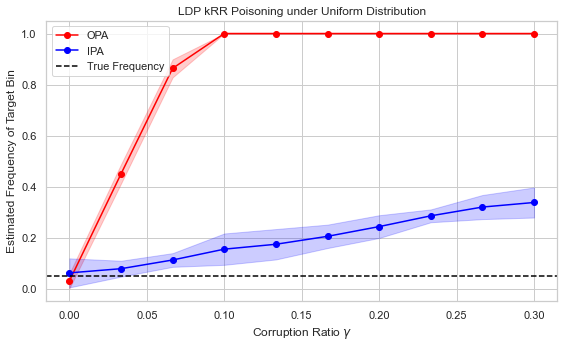

In [14]:
## Uniform Distribution
uniform_freq = np.ones(k) / k
run_experiment(uniform_freq, "Uniform")

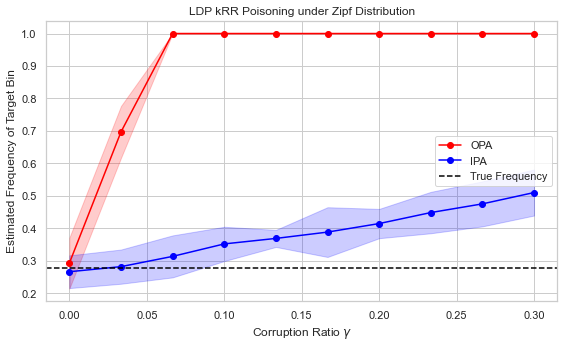

In [15]:
## Zipf Distribution
zipf_freq = zipf_distribution(k, s=1.0)
run_experiment(zipf_freq, "Zipf")

## Conclusion
This simulation compares input and output poisoning attacks under two distributions:

- **OPA** poses greater risk by circumventing noise.
- **IPA** remains bounded but can still bias estimates.
- **Zipf distributions** increase the risk to highly ranked bins.

Mitigation strategies should consider the interplay between data skew and adversarial capability under LDP.